In [1]:
import pandas as pd
from datetime import datetime
from typing import Tuple
import numpy as np
import fredapi
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
TRADING_DAYS_PER_YEAR = 252

In [4]:
ticker = 'FB'

In [5]:
# Procitaj listu svih opcija za FB
options_list_df = pd.read_csv('../data/options_list.csv')
options_list_fb_df = options_list_df.loc[options_list_df['Ticker'] == ticker]
options_list_fb_df

,Contract Name,Ticker
163665,FB220401C00100000,FB
163666,FB220401C00140000,FB
163667,FB220401C00145000,FB
163668,FB220401C00150000,FB
163669,FB220401C00155000,FB
...,...,...
167337,FB240119P00580000,FB
167338,FB240119P00590000,FB
167339,FB240119P00600000,FB
167340,FB240119P00650000,FB


In [7]:
historical_prices_fb_df = pd.read_csv(f'../data/stocks_historical_prices/{ticker}.csv')

# transform Date to datetime64
historical_prices_fb_df['Date'] = pd.to_datetime(historical_prices_fb_df['Date'], format='%Y-%m-%d')

           Date        Open        High         Low       Close   Adj Close  \
0    2012-05-18   42.049999   45.000000   38.000000   38.230000   38.230000   
1    2012-05-21   36.529999   36.660000   33.000000   34.029999   34.029999   
2    2012-05-22   32.610001   33.590000   30.940001   31.000000   31.000000   
3    2012-05-23   31.370001   32.500000   31.360001   32.000000   32.000000   
4    2012-05-24   32.950001   33.209999   31.770000   33.029999   33.029999   
...         ...         ...         ...         ...         ...         ...   
2526 2022-06-02  188.449997  200.940002  187.729996  198.860001  198.860001   
2527 2022-06-03  195.979996  196.610001  189.779999  190.779999  190.779999   
2528 2022-06-06  193.990005  196.919998  188.399994  194.250000  194.250000   
2529 2022-06-07  191.929993  196.529999  191.490005  195.649994  195.649994   
2530 2022-06-08  194.669998  202.029999  194.490005  196.639999  196.639999   

         Volume  
0     573576400  
1     168192700

In [8]:
# calculate annualized volatility
def get_annualized_volatility(historical_prices_df, date) -> float:

    previous_back_days_df = historical_prices_df[historical_prices_df['Date'] < date].tail(
        TRADING_DAYS_PER_YEAR)

    returns_df = previous_back_days_df['Close'].pct_change()

    # calculate annualized volatility
    annualized_volatility = np.std(returns_df) * np.sqrt(TRADING_DAYS_PER_YEAR)

    return annualized_volatility

annualized_volatility = historical_prices_fb_df.apply(
    lambda row: get_annualized_volatility(historical_prices_fb_df, row['Date']), axis=1)
historical_prices_fb_df['Annualized_Volatility'] = annualized_volatility

In [9]:
def read_occ_option_symbol(occ_option_symbol) -> Tuple[datetime, str, float]:
    """
    Read OCC option symbol and return expiration date, option type and strike price.

    Args:
        occ_option_symbol (str): OCC option symbol

    Returns:
        Tuple[datetime, str, float]: Expiration date, option type and strike price
    """

    # read occ until first digit
    ticker = ""
    for i in range(len(occ_option_symbol)):
        if occ_option_symbol[i].isdigit():
            break
        ticker += occ_option_symbol[i]

    # read expiration date
    len_ticker = len(ticker)
    expiration = occ_option_symbol[len_ticker:len_ticker+6]  # 220330 -> 30. ozujak 2022
    offset = 6
    if int(expiration[:2]) > 30:
        expiration_year = "19" + expiration[:2]
    else:
        expiration_year = "20" + expiration[:2]
    expiration_month = expiration[2:4]
    expiration_day = expiration[4:6]
    expiration_date = expiration_year + "-" + \
        expiration_month + "-" + expiration_day
    expiration_date = datetime.strptime(expiration_date, "%Y-%m-%d")

    # read option type
    option_type = occ_option_symbol[len_ticker+offset]
    offset += 1

    # read strike price
    strike_price = int(occ_option_symbol[len_ticker+offset:])

    return expiration_date, option_type, strike_price/1000.0


In [10]:

option_underlying_df = pd.DataFrame()
for contract in options_list_fb_df['Contract Name']:
    contract_df = pd.read_csv(
        f'../data/options_historical_prices/{contract}.csv')
    expiration_date, option_type, strike_price = read_occ_option_symbol(
        contract)
    contract_df['Expiration_Date'] = expiration_date
    contract_df['Option_Type'] = option_type
    contract_df['Strike_Price'] = strike_price
    option_underlying_df = pd.concat(
        [option_underlying_df, contract_df], axis=0, ignore_index=True)

option_underlying_df['Date'] = pd.to_datetime(option_underlying_df['Date'], format='%Y-%m-%d')
option_underlying_df.drop(
    columns=['Open', 'High', 'Low', 'Adj Close'], inplace=True)
option_underlying_df['Volume'] = option_underlying_df['Volume'].astype(int)
option_underlying_df.rename(columns={'Close': 'Option_Close'}, inplace=True)
option_underlying_df.rename(columns={'Volume': 'Option_Volume'}, inplace=True)
option_underlying_df = pd.merge(
    historical_prices_fb_df, option_underlying_df, how='outer')
option_underlying_df.drop(
    columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
option_underlying_df.rename(columns={'Close': 'Stock_Close'}, inplace=True)
option_underlying_df = option_underlying_df.dropna()
option_underlying_df


,Date,Stock_Close,Annualized_Volatility,Option_Close,Option_Volume,Expiration_Date,Option_Type,Strike_Price
2051,2020-07-15,240.279999,0.405832,39.000000,5.0,2022-06-17,P,225.0
2052,2020-07-15,240.279999,0.405832,66.099998,2.0,2022-06-17,P,270.0
2053,2020-07-15,240.279999,0.405832,97.349998,2.0,2022-06-17,P,315.0
2054,2020-07-15,240.279999,0.405832,137.250000,4.0,2022-06-17,P,365.0
2055,2020-07-15,240.279999,0.405832,21.180000,78.0,2022-09-16,P,175.0
...,...,...,...,...,...,...,...,...
151616,2022-06-07,195.649994,0.492214,109.980003,1.0,2024-01-19,P,300.0
151617,2022-06-07,195.649994,0.492214,128.500000,1.0,2024-01-19,P,320.0
151618,2022-06-07,195.649994,0.492214,136.979996,1.0,2024-01-19,P,330.0
151619,2022-06-07,195.649994,0.492214,185.009995,1.0,2024-01-19,P,380.0


In [11]:
fred = fredapi.Fred(api_key='3ec28a08f31fa9ce4cfe75123284ece3')
interest_rates_df = fred.get_series('DGS3MO')

interest_rates_df = interest_rates_df.reset_index()
interest_rates_df.columns = ['Date', 'Interest_Rate']
interest_rates_df['Date'] = pd.to_datetime(interest_rates_df['Date'], format='%Y-%m-%d')
interest_rates_df['Interest_Rate'] = interest_rates_df['Interest_Rate'].astype(float)
interest_rates_df['Interest_Rate'] = interest_rates_df['Interest_Rate'] / 100
interest_rates_df = interest_rates_df.dropna()
interest_rates_df

option_underlying_df = pd.merge(option_underlying_df, interest_rates_df, on='Date', how='left')
option_underlying_df = option_underlying_df.dropna()

In [13]:
def get_days_till_expiration(start_date, end_date) -> int:
    return np.busday_count(start_date, end_date)


option_underlying_df['Days_Till_Expiration'] = option_underlying_df.apply(
    lambda row: get_days_till_expiration(row['Date'].date(), row['Expiration_Date'].date()), axis=1)


In [14]:
option_underlying_2021_df = option_underlying_df[option_underlying_df['Date'].dt.year == 2021]
option_underlying_2022_df = option_underlying_df[option_underlying_df['Date'].dt.year == 2022]
option_underlying_2022_df = option_underlying_2022_df.sample(n=6000)
option_underlying_2021_df = option_underlying_2021_df.sample(n=3000)

# find date with least rows
min_date = min(option_underlying_2021_df['Date'].min(), option_underlying_2022_df['Date'].min())


specific_date_df = option_underlying_df[option_underlying_df['Date'] == '2020-07-31']

# merge option_underlying_2021_df and option_underlying_2022_df to option_underlying_2021_df
option_underlying_df = pd.concat([option_underlying_2021_df, option_underlying_2022_df], axis=0, ignore_index=True)

# sort them by date
option_underlying_df = option_underlying_df.sort_values(by=['Date'])
#
# specific_date_df = option_underlying_df[option_underlying_df['Date'] == '2022-04-28']

In [15]:
# dodavanje stupca up i down faktora za svaki dan (naivno)
cache_naive = {}

def get_up_down_naive(historical_prices_df, date, back_days) -> Tuple[float, float]:
    
    if (date, back_days) in cache_naive:
        return cache_naive[(date, back_days)]
    
    # get previous 50 days
    if back_days > TRADING_DAYS_PER_YEAR:
        previous_back_days_df = historical_prices_df[historical_prices_df['Date'] < date].tail(
        back_days)
    else: # calculate annualized volatility
        back_days = TRADING_DAYS_PER_YEAR
        previous_back_days_df = historical_prices_df[historical_prices_df['Date'] < date].tail(
        TRADING_DAYS_PER_YEAR)
    
    returns_df = previous_back_days_df['Close'].pct_change()


    # count number of days with positive return
    u = np.mean(returns_df[returns_df > 0])

    # count number of days with negative return
    d = np.mean(returns_df[returns_df < 0])

    cache_naive[(date, back_days)] = (1 + u, 1 + d)


    return 1 + u, 1 + d


up_down_factors = option_underlying_df.apply(
    lambda row: get_up_down_naive(historical_prices_fb_df, row['Date'], row['Days_Till_Expiration']), axis=1)
option_underlying_df[['Up_Factor_Naive', 'Down_Factor_Naive']] = pd.DataFrame(
    up_down_factors.tolist(), index=option_underlying_df.index)

up_down_factors_specific = specific_date_df.apply(
    lambda row: get_up_down_naive(historical_prices_fb_df, row['Date'], row['Days_Till_Expiration']), axis=1)
specific_date_df[['Up_Factor_Naive', 'Down_Factor_Naive']] = pd.DataFrame(
    up_down_factors_specific.tolist(), index=specific_date_df.index)


/var/folders/24/pqjg8zc57vzdsd43bycd8y6m0000gn/T/ipykernel_61687/1649258738.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_date_df[['Up_Factor_Naive', 'Down_Factor_Naive']] = pd.DataFrame(
/var/folders/24/pqjg8zc57vzdsd43bycd8y6m0000gn/T/ipykernel_61687/1649258738.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_date_df[['Up_Factor_Naive', 'Down_Factor_Naive']] = pd.DataFrame(


In [16]:
# calculate using underlying stock
cache_volatility = {}


def get_up_down_underlying_volatility(date, back_days, historical_prices_df) -> Tuple[float, float]:

    
    t = 1 / TRADING_DAYS_PER_YEAR
    
    if back_days < TRADING_DAYS_PER_YEAR:
        annualized_volatility = historical_prices_df[historical_prices_df['Date'] == date]['Annualized_Volatility'].values[0]
        u = np.exp(annualized_volatility * np.sqrt(t))
        d = 1 / u
        return u, d

    
    if (date, back_days) in cache_volatility:
        return cache_volatility[(date, back_days)]

    previous_back_days_df = historical_prices_df[historical_prices_df['Date'] < date].tail(
        back_days)

    returns_df = previous_back_days_df['Close'].pct_change()

    # calculate annualized volatility
    volatility = np.std(returns_df) * np.sqrt(TRADING_DAYS_PER_YEAR)

    u = np.exp(volatility * np.sqrt(t))
    d = 1 / u

    cache_volatility[(date, back_days)] = (u, d)

    return u, d


up_down_factors = option_underlying_df.apply(
    lambda row: get_up_down_underlying_volatility(row['Date'], row['Days_Till_Expiration'], historical_prices_fb_df), axis=1)
option_underlying_df[['Up_Factor_Volatility', 'Down_Factor_Volatility']] = pd.DataFrame(
    up_down_factors.tolist(), index=option_underlying_df.index)

up_down_factors_specific_date = specific_date_df.apply(
    lambda row: get_up_down_underlying_volatility(row['Date'], row['Days_Till_Expiration'], historical_prices_fb_df), axis=1)
specific_date_df[['Up_Factor_Volatility', 'Down_Factor_Volatility']] = pd.DataFrame(
    up_down_factors_specific_date.tolist(), index=specific_date_df.index)


/var/folders/24/pqjg8zc57vzdsd43bycd8y6m0000gn/T/ipykernel_61687/2119802354.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_date_df[['Up_Factor_Volatility', 'Down_Factor_Volatility']] = pd.DataFrame(
/var/folders/24/pqjg8zc57vzdsd43bycd8y6m0000gn/T/ipykernel_61687/2119802354.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_date_df[['Up_Factor_Volatility', 'Down_Factor_Volatility']] = pd.DataFrame(


In [17]:
def risk_neutral_pricing_formula_american(S, u, d, K, r, T, option_type) -> float:
    
    dt = 1 / TRADING_DAYS_PER_YEAR
    N = int(TRADING_DAYS_PER_YEAR * T)

    p = (np.exp(r * dt) - d) / (u - d)
    q = 1 - p

    # Inicijalizacija stabla cijena dionice
    stock_tree = np.zeros((N + 1, N + 1))
    stock_tree[0, 0] = S
    for i in range(1, N + 1):
        stock_tree[0, i] = stock_tree[0, i - 1] * u
        for j in range(1, i + 1):
            stock_tree[j, i] = stock_tree[j - 1, i - 1] * d

    # Inicijalizacija stabla vrijednosti opcije
    option_tree = np.zeros((N + 1, N + 1))
    if option_type == 'C':
        for i in range(N + 1):
            option_tree[i, N] = max(stock_tree[i, N] - K, 0)
    elif option_type == 'P':
        for i in range(N + 1):
            option_tree[i, N] = max(K - stock_tree[i, N], 0)

    # Racunanje vrijednosti opcije na svakom cvoru stabla
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            if option_type == 'C':
                intrinsic_value = stock_tree[j, i] - K
            elif option_type == 'P':
                intrinsic_value = K - stock_tree[j, i]

            exercise_value = np.exp(-r * dt) * (
                p * option_tree[j, i + 1] + q * option_tree[j + 1, i + 1]
            )

            option_tree[j, i] = max(intrinsic_value, exercise_value)

    return option_tree[0, 0]


In [18]:
def calculate_fair_value_naive(row):
    S = row['Stock_Close']
    u = row['Up_Factor_Naive']
    d = row['Down_Factor_Naive']
    K = row['Strike_Price']
    r = row['Interest_Rate']
    T = row['Days_Till_Expiration']/TRADING_DAYS_PER_YEAR
    option_type = row['Option_Type']
    return risk_neutral_pricing_formula_american(S, u, d, K, r, T, option_type)

option_underlying_df.loc[:, 'Fair_Value_Naive'] = option_underlying_df.apply(calculate_fair_value_naive, axis=1)
specific_date_df.loc[:, 'Fair_Value_Naive'] = specific_date_df.apply(calculate_fair_value_naive, axis=1)

/var/folders/24/pqjg8zc57vzdsd43bycd8y6m0000gn/T/ipykernel_61687/1104887653.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_date_df.loc[:, 'Fair_Value_Naive'] = specific_date_df.apply(calculate_fair_value_naive, axis=1)


In [20]:
def calculate_fair_value_volatility(row):
    S = row['Stock_Close']
    u = row['Up_Factor_Volatility']
    d = row['Down_Factor_Volatility']
    K = row['Strike_Price']
    r = row['Interest_Rate']
    T = row['Days_Till_Expiration']/TRADING_DAYS_PER_YEAR
    option_type = row['Option_Type']
    return risk_neutral_pricing_formula_american(S, u, d, K, r, T, option_type)

option_underlying_df.loc[:, 'Fair_Value_Volatility'] = option_underlying_df.apply(calculate_fair_value_volatility, axis=1)
specific_date_df.loc[:, 'Fair_Value_Volatility'] = specific_date_df.apply(calculate_fair_value_volatility, axis=1)

/var/folders/24/pqjg8zc57vzdsd43bycd8y6m0000gn/T/ipykernel_61687/1248306313.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_date_df.loc[:, 'Fair_Value_Volatility'] = specific_date_df.apply(calculate_fair_value_volatility, axis=1)


Početak analize:

In [22]:
def calculate_mape_mpe(actual, predicted):
    pe = (actual - predicted) / actual
    ape = np.abs(pe)

    # Calculate MAPE and MPE
    mape = np.mean(ape) * 100
    mpe = np.mean(pe) * 100
    
    print("MAPE:", mape)
    print("MPE:", mpe)
    print("====================================")

In [24]:
colors = ['#9ab927',
          '#d4c44d',
          '#14848f',
          '#5ab4bd',
          '#1d445f',
          '#f48623',
          '#fdae49',
          '#c27715',
          '#a80a0a']

sns.set_palette(sns.color_palette(colors))

# Set the figure size and font sizes
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

<Figure size 800x600 with 0 Axes>

/var/folders/24/pqjg8zc57vzdsd43bycd8y6m0000gn/T/ipykernel_61687/40040337.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_date_df.loc[:,'Relative_Error_Naive'] = ((specific_date_df['Option_Close'] - specific_date_df['Fair_Value_Naive']) / specific_date_df['Option_Close']) * 100
/var/folders/24/pqjg8zc57vzdsd43bycd8y6m0000gn/T/ipykernel_61687/40040337.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_date_df.loc[:,'Relative_Error_Volatility'] =  ((specific_date_df['Option_Close'] - sp

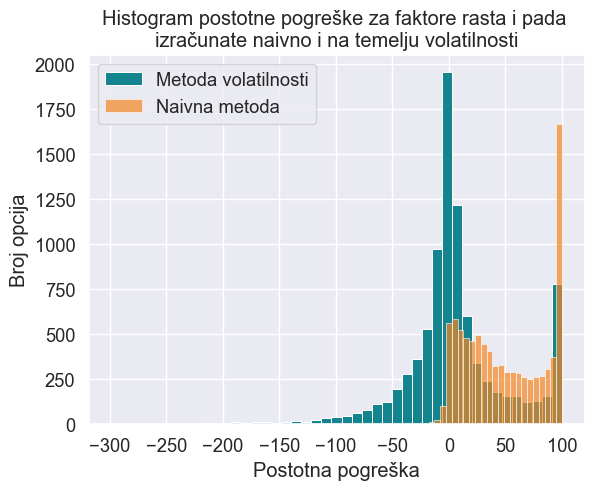

MAPE and MPE for Fair_Value_Naive
MAPE: 49.90401163697886
MPE: 49.64048460327542
MAPE and MPE for Fair_Value_Volatility
MAPE: 31.08658205108962
MPE: 6.159817049127014


In [25]:
option_underlying_df.loc[:,'Relative_Error_Naive'] = ((option_underlying_df['Option_Close'] - option_underlying_df['Fair_Value_Naive']) / option_underlying_2021_df['Option_Close']) * 100
option_underlying_df.loc[:,'Relative_Error_Volatility'] =  ((option_underlying_df['Option_Close'] - option_underlying_df['Fair_Value_Volatility']) / option_underlying_df['Option_Close']) * 100


specific_date_df.loc[:,'Relative_Error_Naive'] = ((specific_date_df['Option_Close'] - specific_date_df['Fair_Value_Naive']) / specific_date_df['Option_Close']) * 100
specific_date_df.loc[:,'Relative_Error_Volatility'] =  ((specific_date_df['Option_Close'] - specific_date_df['Fair_Value_Volatility']) / specific_date_df['Option_Close']) * 100


sns.histplot(data=option_underlying_df, x="Relative_Error_Volatility", bins=45, label='Metoda volatilnosti', alpha=1, color = colors[2])
sns.histplot(data=option_underlying_df, x="Relative_Error_Naive", bins=28, label='Naivna metoda', alpha=0.7, color = colors[5])

plt.xlabel('Postotna pogreška')
plt.ylabel('Broj opcija')
plt.title('Histogram postotne pogreške za faktore rasta i pada \nizračunate naivno i na temelju volatilnosti')
plt.legend()
plt.savefig('histogram_vol_naive.pdf', format='pdf', bbox_inches='tight')
plt.show()

print("MAPE and MPE for Fair_Value_Naive")
calculate_mape_mpe(option_underlying_df['Option_Close'], option_underlying_df['Fair_Value_Naive'])
print("MAPE and MPE for Fair_Value_Volatility")
calculate_mape_mpe(option_underlying_df['Option_Close'], option_underlying_df['Fair_Value_Volatility'])

In [28]:
option_underlying_df_without_clearing = option_underlying_df.copy()

specific_date_df = specific_date_df[(specific_date_df['Relative_Error_Volatility'] < 99) & (specific_date_df['Relative_Error_Volatility'] > -99)]
option_underlying_df = option_underlying_df[(option_underlying_df['Relative_Error_Volatility'] < 99) & (option_underlying_2021_df['Relative_Error_Volatility'] > -99)]

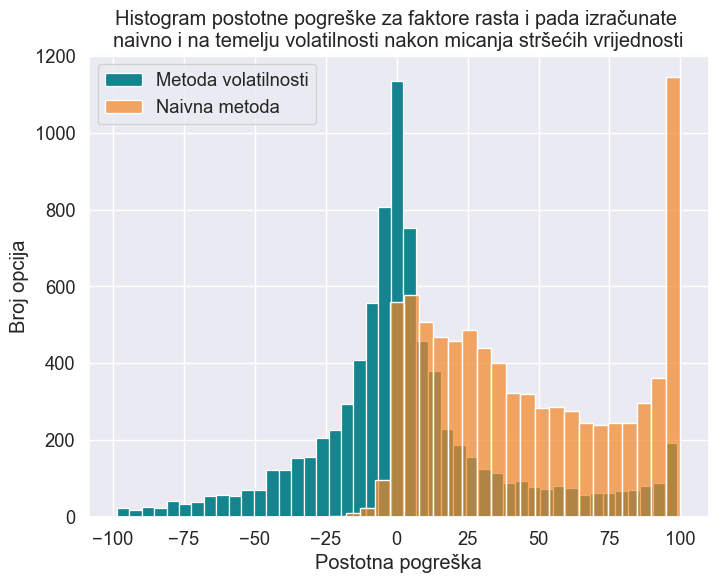

MAPE and MPE for Fair_Value_Naive
MAPE: 46.65779376243515
MPE: 46.37765561159853
MAPE and MPE for Fair_Value_Volatility
MAPE: 24.231919219341954
MPE: 3.86991128788984


In [40]:
sns.histplot(data=option_underlying_2021_df, x="Relative_Error_Volatility", bins=45, label='Metoda volatilnosti', alpha=1, color = colors[2])
sns.histplot(data=option_underlying_2021_df, x="Relative_Error_Naive", bins=28, label='Naivna metoda', alpha=0.7, color = colors[5])
plt.xlabel('Postotna pogreška')
plt.ylabel('Broj opcija')
plt.title('Histogram postotne pogreške za faktore rasta i pada izračunate \nnaivno i na temelju volatilnosti nakon micanja stršećih vrijednosti')
plt.legend()

# plt.savefig('histogram_vol_naive_clear.pdf', format='pdf', bbox_inches='tight')
plt.show()

print("MAPE and MPE for Fair_Value_Naive")
calculate_mape_mpe(option_underlying_2021_df['Option_Close'], option_underlying_2021_df['Fair_Value_Naive'])
print("MAPE and MPE for Fair_Value_Volatility")
calculate_mape_mpe(option_underlying_2021_df['Option_Close'], option_underlying_2021_df['Fair_Value_Volatility'])

Mozemo razmotriti koje opcije (call ili put) tocnije vrednuje. Plottat cemo P i C graf

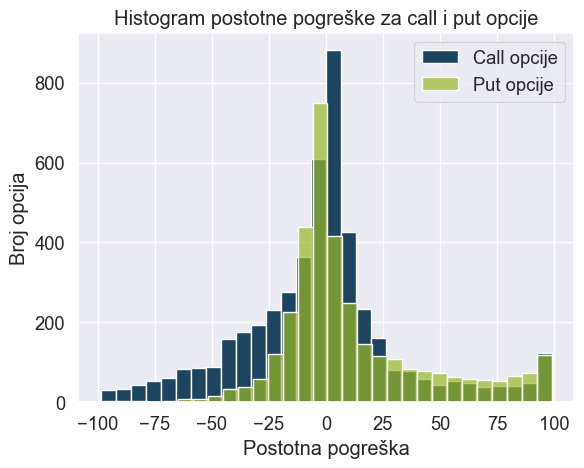

MAPE and MPE for Call
MAPE: 25.03837611569898
MPE: -2.029153112332811
MAPE and MPE for Put
MAPE: 23.105580170677033
MPE: 12.108847075498732


In [34]:
option_underlying_call_df = option_underlying_df.loc[(
    option_underlying_df['Option_Type'] == 'C')]
option_underlying_put_df = option_underlying_df.loc[(
    option_underlying_df['Option_Type'] == 'P')]

option_underlying_call_bad_df = option_underlying_df_without_clearing.loc[(
    option_underlying_df_without_clearing['Option_Type'] == 'C')]
option_underlying_put_bad_df = option_underlying_df_without_clearing.loc[(
    option_underlying_df_without_clearing['Option_Type'] == 'P')]

sns.histplot(data=option_underlying_call_df, x="Relative_Error_Volatility",
             bins=30, label='Call opcije', alpha=1, color=colors[4])
sns.histplot(data=option_underlying_put_df, x="Relative_Error_Volatility",
             bins=30, label='Put opcije', alpha=0.7, color=colors[0])

plt.xlabel('Postotna pogreška')
plt.ylabel('Broj opcija')
plt.title('Histogram postotne pogreške za call i put opcije')
plt.legend()
# plt.savefig('histogram_call_put.pdf', format='pdf', bbox_inches='tight')
plt.show()

print("MAPE and MPE for Call")
calculate_mape_mpe(option_underlying_call_df['Option_Close'],
                   option_underlying_call_df['Fair_Value_Volatility'])
print("MAPE and MPE for Put")
calculate_mape_mpe(
    option_underlying_put_df['Option_Close'], option_underlying_put_df['Fair_Value_Volatility'])


/var/folders/24/pqjg8zc57vzdsd43bycd8y6m0000gn/T/ipykernel_61687/3451013433.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_underlying_itm_df = option_underlying_itm_df.append(option_underlying_put_df.loc[(option_underlying_put_df['Stock_Close'] < option_underlying_put_df['Strike_Price'])])
/var/folders/24/pqjg8zc57vzdsd43bycd8y6m0000gn/T/ipykernel_61687/3451013433.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_underlying_otm_df = option_underlying_otm_df.append(option_underlying_put_df.loc[(option_underlying_put_df['Stock_Close'] > option_underlying_put_df['Strike_Price'])])
/var/folders/24/pqjg8zc57vzdsd43bycd8y6m0000gn/T/ipykernel_61687/3451013433.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

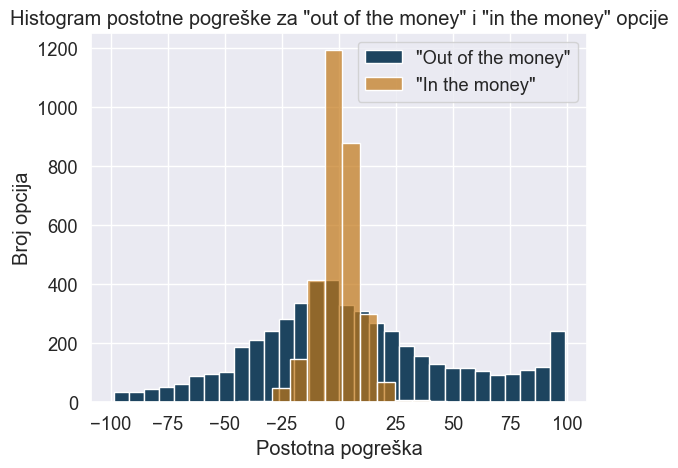

MAPE and MPE for ITM
MAPE: 6.491213380844379
MPE: -0.1585059925851386
MAPE and MPE for OTM
MAPE: 34.674018560945186
MPE: 6.241019507319814


In [41]:
option_underlying_itm_df = option_underlying_call_df.loc[(option_underlying_call_df['Stock_Close'] > option_underlying_call_df['Strike_Price'])]
option_underlying_itm_df = option_underlying_itm_df.append(option_underlying_put_df.loc[(option_underlying_put_df['Stock_Close'] < option_underlying_put_df['Strike_Price'])])

option_underlying_otm_df = option_underlying_call_df.loc[(option_underlying_call_df['Stock_Close'] < option_underlying_call_df['Strike_Price'])]
option_underlying_otm_df = option_underlying_otm_df.append(option_underlying_put_df.loc[(option_underlying_put_df['Stock_Close'] > option_underlying_put_df['Strike_Price'])])

option_underlying_bad_itm_df = option_underlying_call_bad_df.loc[(option_underlying_call_bad_df['Stock_Close'] > option_underlying_call_bad_df['Strike_Price'])]
option_underlying_bad_itm_df = option_underlying_bad_itm_df.append(option_underlying_put_bad_df.loc[(option_underlying_put_bad_df['Stock_Close'] < option_underlying_put_bad_df['Strike_Price'])])

option_underlying_bad_otm_df = option_underlying_call_bad_df.loc[(option_underlying_call_bad_df['Stock_Close'] < option_underlying_call_bad_df['Strike_Price'])]
option_underlying_bad_otm_df = option_underlying_bad_otm_df.append(option_underlying_put_bad_df.loc[(option_underlying_put_bad_df['Stock_Close'] > option_underlying_put_bad_df['Strike_Price'])])

sns.histplot(data=option_underlying_otm_df, x="Relative_Error_Volatility", bins=30, label='"Out of the money"', color=colors[4], alpha=1)
sns.histplot(data=option_underlying_itm_df, x="Relative_Error_Volatility", bins=16, label='"In the money"', color=colors[7], alpha=0.7)

plt.xlabel('Postotna pogreška')
plt.ylabel('Broj opcija')
plt.title('Histogram postotne pogreške za "out of the money" i "in the money" opcije')
plt.legend()
# plt.savefig('histogram_moneyness.pdf', format='pdf', bbox_inches='tight')
plt.show()

print("MAPE and MPE for ITM")
calculate_mape_mpe(option_underlying_itm_df['Option_Close'], option_underlying_itm_df['Fair_Value_Volatility'])
print("MAPE and MPE for OTM")
calculate_mape_mpe(option_underlying_otm_df['Option_Close'], option_underlying_otm_df['Fair_Value_Volatility'])

In [36]:
sum_volume_itm = option_underlying_itm_df['Option_Volume'].sum()
sum_volume_otm = option_underlying_otm_df['Option_Volume'].sum()

sum_volume_otm_bad = option_underlying_bad_otm_df['Option_Volume'].sum()
sum_volume_itm_bad = option_underlying_bad_itm_df['Option_Volume'].sum()

print("Sum volume ITM: ", sum_volume_itm)
print("Sum volume OTM: ", sum_volume_otm)
print("Sum volume ITM bad: ", sum_volume_itm_bad)
print("Sum volume OTM bad: ", sum_volume_otm_bad)

ratio_bad = sum_volume_itm_bad / sum_volume_otm_bad
ratio = sum_volume_itm / sum_volume_otm
print("Ratio of ITM to OTM before cleaning: ", ratio_bad)
print("Ratio of ITM to OTM after cleaning: ", ratio)

Sum volume ITM:  20635781.0
Sum volume OTM:  87863725.0
Sum volume ITM bad:  20635781.0
Sum volume OTM bad:  140765822.0
Ratio of ITM to OTM before cleaning:  0.14659652966044556
Ratio of ITM to OTM after cleaning:  0.23486121263354132


In [37]:
specific_date_call_df = specific_date_df.loc[(specific_date_df['Option_Type'] == 'C')]
specific_date_put_df = specific_date_df.loc[(specific_date_df['Option_Type'] == 'P')]
specific_date_call_df

,Date,Stock_Close,Annualized_Volatility,Option_Close,Option_Volume,Expiration_Date,Option_Type,Strike_Price,Interest_Rate,Days_Till_Expiration,Up_Factor_Naive,Down_Factor_Naive,Up_Factor_Volatility,Down_Factor_Volatility,Fair_Value_Naive,Fair_Value_Volatility,Relative_Error_Naive,Relative_Error_Volatility


In [39]:
stock_price = specific_date_call_df['Stock_Close'].iloc[0]
filtered_data_call_low = specific_date_call_df[specific_date_call_df['Strike_Price'] < stock_price]
filtered_data_call_high = specific_date_call_df[specific_date_call_df['Strike_Price'] > stock_price]

sns.scatterplot(data=filtered_data_call_high, x="Days_Till_Expiration", y="Relative_Error_Volatility", label='"In the money"', alpha=1, c=colors[4], s=60, linewidth=0.3)
sns.scatterplot(data=filtered_data_call_low, x="Days_Till_Expiration", y="Relative_Error_Volatility", label='"Out of the money"', alpha=1, c=colors[7], s=60, linewidth=0.3)


plt.xlabel('Dani do dospijeća')
plt.ylabel('Postotna pogreška')
plt.title('Ovisnost postotne pogreške o danima do dospijeća za opcije s \nrazličitim cijenama izvršavanja za call opcije izdane 28. travnja 2022.')
plt.legend()
# plt.savefig('call_28_04_2022_new.pdf', format='pdf', bbox_inches='tight')
plt.show()


IndexError: single positional indexer is out-of-bounds

Ovdje se vidi da za niske dane do dospijeća podcjenjuje, tocno nakon nekih 5 mjeseci

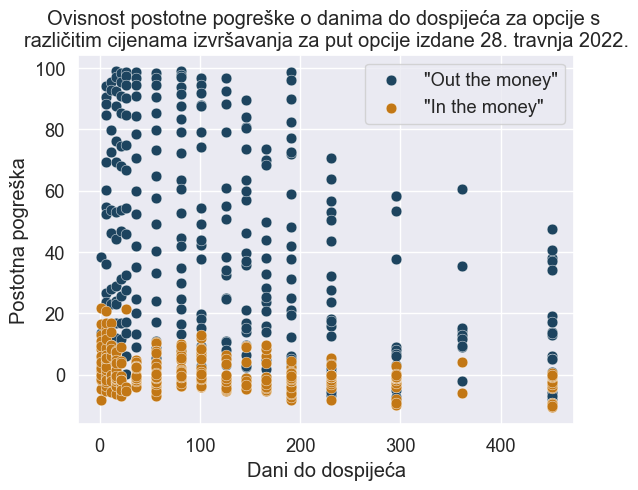

In [ ]:
stock_price = specific_date_put_df['Stock_Close'].iloc[0]
filtered_data_put_low = specific_date_put_df[specific_date_put_df['Strike_Price'] < stock_price]
filtered_data_put_high = specific_date_put_df[specific_date_put_df['Strike_Price'] > stock_price]


sns.scatterplot(data=filtered_data_put_low, x="Days_Till_Expiration", y="Relative_Error_Volatility", label='"Out of the money"', alpha=1, c=colors[4], s=60, linewidth=0.3)
sns.scatterplot(data=filtered_data_put_high, x="Days_Till_Expiration", y="Relative_Error_Volatility", label='"In the money"', alpha=1, c=colors[7], s=60, linewidth=0.3)

plt.xlabel('Dani do dospijeća')
plt.ylabel('Postotna pogreška')
plt.title('Ovisnost postotne pogreške o danima do dospijeća za opcije s \nrazličitim cijenama izvršavanja za put opcije izdane 28. travnja 2022.')
plt.legend()
# plt.savefig('put_28_04_2022_new.pdf', format='pdf', bbox_inches='tight')
plt.show()

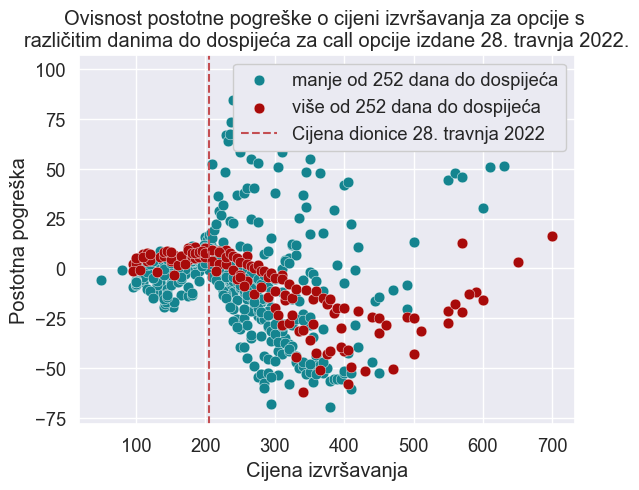

In [ ]:
filtered_data_call_low = specific_date_call_df[specific_date_call_df['Days_Till_Expiration'] <= TRADING_DAYS_PER_YEAR]
filtered_data_call_high = specific_date_call_df[specific_date_call_df['Days_Till_Expiration'] > TRADING_DAYS_PER_YEAR]

sns.scatterplot(data=filtered_data_call_low, x="Strike_Price", y="Relative_Error_Volatility", label='manje od 252 dana do dospijeća', alpha=1, c=colors[2], s=60, linewidth=0.3)
sns.scatterplot(data=filtered_data_call_high, x="Strike_Price", y="Relative_Error_Volatility", label='više od 252 dana do dospijeća', alpha=1, c=colors[8], s=60, linewidth=0.3)

plt.xlabel('Cijena izvršavanja')
plt.ylabel('Postotna pogreška')
plt.title('Ovisnost postotne pogreške o cijeni izvršavanja za opcije s \nrazličitim danima do dospijeća za call opcije izdane 28. travnja 2022.')

plt.axvline(x=specific_date_call_df['Stock_Close'].iloc[0], color='r', linestyle='--', label='Cijena dionice 28. travnja 2022')

plt.legend()
plt.legend(loc='upper right', framealpha=1)

# plt.savefig('call_28_04_2022_days_new.pdf', format='pdf', bbox_inches='tight')

plt.show()

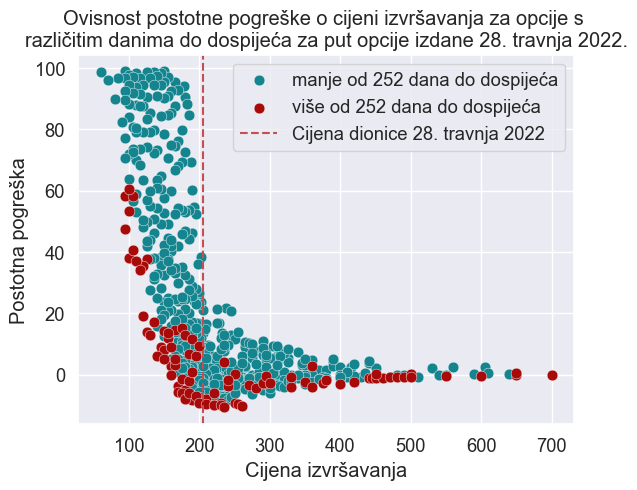

In [ ]:
filtered_data_put_low = specific_date_put_df[specific_date_put_df['Days_Till_Expiration'] <= TRADING_DAYS_PER_YEAR]
filtered_data_put_high = specific_date_put_df[specific_date_put_df['Days_Till_Expiration'] > TRADING_DAYS_PER_YEAR]

sns.scatterplot(data=filtered_data_put_low, x="Strike_Price", y="Relative_Error_Volatility", label='manje od 252 dana do dospijeća', alpha=1, c=colors[2], s=60, linewidth=0.3)
sns.scatterplot(data=filtered_data_put_high, x="Strike_Price", y="Relative_Error_Volatility", label='više od 252 dana do dospijeća', alpha=1, c=colors[8], s=60, linewidth=0.3)


plt.xlabel('Cijena izvršavanja')
plt.ylabel('Postotna pogreška')
plt.title('Ovisnost postotne pogreške o cijeni izvršavanja za opcije s \nrazličitim danima do dospijeća za put opcije izdane 28. travnja 2022.')

plt.axvline(x=specific_date_put_df['Stock_Close'].iloc[0], color='r', linestyle='--', label='Cijena dionice 28. travnja 2022')

plt.legend()
# plt.savefig('put_28_04_2022_days_new.pdf', format='pdf', bbox_inches='tight')
plt.show()


/Users/edimac/Documents/FER/6_sem/zavrad/binomial_model/binomial_model_venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/edimac/Documents/FER/6_sem/zavrad/binomial_model/binomial_model_venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


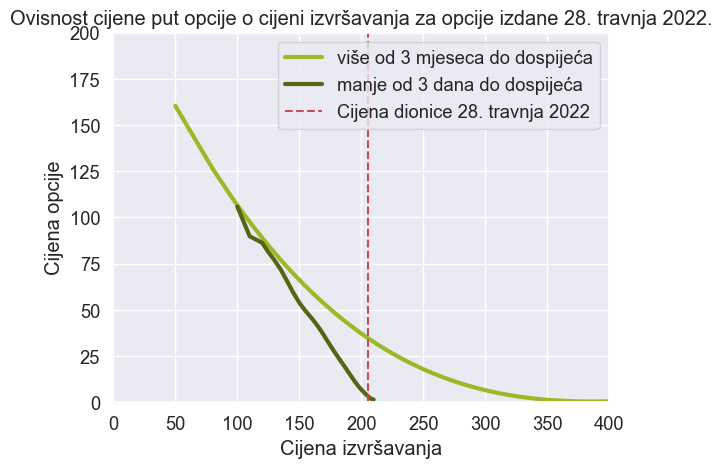

In [ ]:
put_less_than_30_df = specific_date_put_df[specific_date_put_df['Days_Till_Expiration'] < 3]
call_less_than_30_df = specific_date_call_df[specific_date_call_df['Days_Till_Expiration'] < 3]
put_greater_than_or_equal_30_df = specific_date_put_df[specific_date_put_df['Days_Till_Expiration'] >= 90]
call_greater_than_or_equal_30_df = specific_date_call_df[specific_date_call_df['Days_Till_Expiration'] >= 90]

put_greater_than_or_equal_30_df = put_greater_than_or_equal_30_df.sort_values(by=['Strike_Price'])
call_greater_than_or_equal_30_df = call_greater_than_or_equal_30_df.sort_values(by=['Strike_Price'])
put_less_than_30_df = put_less_than_30_df.sort_values(by=['Strike_Price'])
call_less_than_30_df = call_less_than_30_df.sort_values(by=['Strike_Price'])

plt.xlim(0, 400)
plt.ylim(0, 200)

darker='#546515'

polyfit_1 = np.polyfit(put_greater_than_or_equal_30_df['Strike_Price'], put_greater_than_or_equal_30_df['Option_Close'], 3)
polyfit_2 = np.polyfit(call_greater_than_or_equal_30_df['Strike_Price'], call_greater_than_or_equal_30_df['Option_Close'], 3)
polyfit_3 = np.polyfit(put_less_than_30_df['Strike_Price'], put_less_than_30_df['Option_Close'], 15)
polyfit_4 = np.polyfit(call_less_than_30_df['Strike_Price'], call_less_than_30_df['Option_Close'], 15)

sns.lineplot(data=call_greater_than_or_equal_30_df, x="Strike_Price", y=np.polyval(polyfit_2, call_greater_than_or_equal_30_df['Strike_Price']), label='više od 3 mjeseca do dospijeća', c=colors[0], linewidth=3)
sns.lineplot(data=call_less_than_30_df, x="Strike_Price", y=np.polyval(polyfit_4, call_less_than_30_df['Strike_Price']), label='manje od 3 dana do dospijeća', c=darker, linewidth=3)

plt.axvline(x=specific_date_put_df['Stock_Close'].iloc[0], color='r', linestyle='--', label='Cijena dionice 28. travnja 2022')
plt.xlabel('Cijena izvršavanja')
plt.ylabel('Cijena opcije')
plt.title('Ovisnost cijene put opcije o cijeni izvršavanja za opcije izdane 28. travnja 2022.')
plt.legend()
# plt.savefig('payoff_call.pdf', format='pdf', bbox_inches='tight')
plt.show()

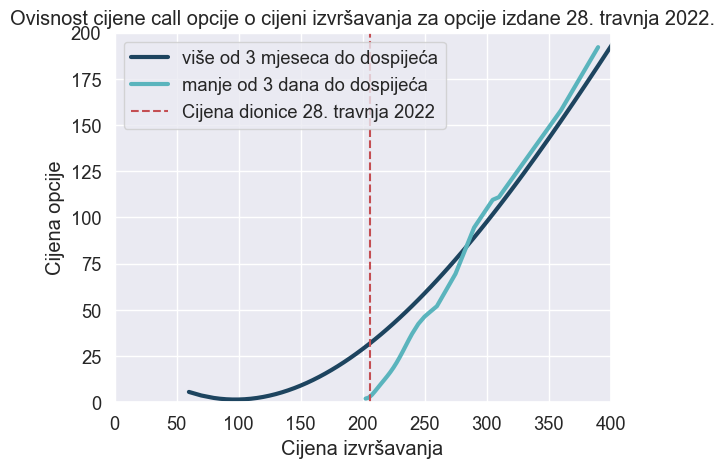

In [ ]:
sns.lineplot(data=put_greater_than_or_equal_30_df, x="Strike_Price", y=np.polyval(polyfit_1, put_greater_than_or_equal_30_df['Strike_Price']), label='više od 3 mjeseca do dospijeća', c=colors[4], linewidth=3)
sns.lineplot(data=put_less_than_30_df, x="Strike_Price", y=np.polyval(polyfit_3, put_less_than_30_df['Strike_Price']), label='manje od 3 dana do dospijeća', c=colors[3], linewidth=3)
plt.axvline(x=specific_date_put_df['Stock_Close'].iloc[0], color='r', linestyle='--', label='Cijena dionice 28. travnja 2022')
plt.legend()
plt.xlabel('Cijena izvršavanja')
plt.ylabel('Cijena opcije')
plt.xlim(0, 400)
plt.ylim(0, 200)
plt.title('Ovisnost cijene call opcije o cijeni izvršavanja za opcije izdane 28. travnja 2022.')
# plt.savefig('payoff_put.pdf', format='pdf', bbox_inches='tight')
plt.show()
